In [1]:
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from typing import List, Dict, Tuple
from collections.abc import Callable
import time
from itertools import chain, combinations

x = sp.IndexedBase('x')
u = sp.IndexedBase('u')
i, j, k = sp.symbols('i j k', cls=sp.Idx)
a, b = sp.symbols('a b')

### Logic

Compute dynamic of the system by given control inputs

In [2]:
def computeDynamic(
    f: List[Callable[[float, float], float]], # dynamic of the system; size must be equal to the number of players
    u: np.ndarray, # control inputs array; shape must be equal to (n, m), where n is the number of players and m is the number of timestamps
    x0: np.ndarray, # initial state of the system; size must be equal to the number of players
    delta_time: float # time between two adjust timestamps
    ) -> np.ndarray: # returns array of shape (n, m + 1) where n is the number of players and m is the number of timestamps
  n = len(f)
  if len(u.shape) == 1:
    m = len(u) // n
    u = u.reshape((n, m))
  else:
    m = u.shape[1]

  x = np.empty((n, m + 1))
  for i in range(n):
    x[i, 0] = x0[i]
    for j in range(1, m + 1):
      x[i, j] = x[i, j - 1] + delta_time * f[i](x[i, j - 1], u[i, j - 1])
  return x

Compute Joint Payoff

In [3]:
def computeJointPayoff(
    f: list[Callable[[float, float], float]], # dynamic of the system; size must be equal to the number of players
    h: dict[tuple[int, int], Callable[[float, float], float]], # payoff of the first player for connecting with second player; must be set for all edges of the graph
    K: list[list[int]], # for each players contains list of their neighbors
    u: np.ndarray, # control inputs array; shape must be equal to (n, m), where n is the number of players and m is the number of timestamps
    x0: np.ndarray, # initial state of the system; size must be equal to the number of players
    delta_time: float, # time between two adjust timestamps
    final_computation = True # if you compute JointPayoff gradually (with splits in timestamps array), this bool must be set to False for all but final step
    ) -> float: # returns calculated joint payoff
  n = len(f)
  if len(u.shape) == 1:
    m = len(u) // n
    u = u.reshape((n, m))
  else:
    m = u.shape[1]

  x = computeDynamic(f, u, x0, delta_time)

  sum = 0
  timestamps = m + 1 if final_computation else m
  for i in range(n):
    for j in K[i]:
      for k in range(timestamps):
        sum += h[(i, j)](x[i, k], x[j, k])
  sum = sum * delta_time
  return sum



Compute Joint Payoff Derivative (need for finding max of Compute Joint Payoff)

In [4]:
def computeJointPayoffDerivative(
    f: list[Callable[[float, float], float]], # dynamic of the system; size must be equal to the number of players
    f_deriv: list[tuple[Callable[[float, float], float], Callable[[float, float], float]]], # for each player contains two partial derivatives of their state dynamic
    h_deriv: dict[tuple[int, int], tuple[Callable[[float, float], float], Callable[[float, float], float]]], # for each edge of graph contains two partial derivatives of player connections payoff function
    K: list[list[int]], # for each players contains list of their neighbors
    u: np.ndarray, # control inputs array; shape must be equal to (n, m), where n is the number of players and m is the number of timestamps
    x0: np.ndarray, # initial state of the system; size must be equal to the number of players
    delta_time: float # time between two adjust timestamps
    ) -> list[float]:
  n = len(f)
  if len(u.shape) == 1:
    m = len(u) // n
    u = u.reshape((n, m))
  else:
    m = u.shape[1]

  x = computeDynamic(f, u, x0, delta_time)

  ans = np.empty((n, m)) # array of first derivatives with respect to u[i, j] (i -- player, j -- time)
  for player in range(n):
    # for computing trajectory of player i (x[i, :]) we only use u[i, :] (u[player, :]), not u[j, :] (i != j)
    dxdu = np.zeros((m + 1, m)) # rows (i) -- x[player, i], columns (j) -- u[player, j], elements: dx_{player, i}/du_{player, j}
    for j in range(m):
      i = j + 1
      dxdu[i][j] = delta_time * f_deriv[player][1](x[player, j], u[player, j])
      for i in range(j + 2, m + 1):
        dxdu[i][j] = dxdu[i - 1][j] * (1 + delta_time * f_deriv[player][0](x[player, i - 1], u[player, i - 1]))
    for time in range(m):
      sum = 0
      for i in range(n):
        for j in K[i]:
          if i != player and j != player:
            continue
          for k in range(m + 1):
            sum += h_deriv[(i, j)][0 if i == player else 1](x[i, k], x[j, k]) * dxdu[k][time]
      ans[player, time] = sum
  return ans.flatten()

Compute $V(N; x_0, T - t_0)$

In [5]:
def findMaxJointPayoff(
    f: list[Callable[[float, float], float]], # dynamic of the system; size must be equal to the number of players
    h: dict[tuple[int, int], Callable[[float, float], float]], # payoff of the first player for connecting with second player; must be set for all edges of the graph
    K: list[list[int]], # for each players contains list of their neighbors
    U: list[tuple[float, float]], # for each player contains lower and upper bounds for possible control inputs
    x0: np.ndarray, # initial state of the system; size must be equal to the number of players
    delta_time: float, # time between two adjust timestamps
    m: int, # number of timestamps
    final_computation = True # if you compute JointPayoff gradually (with splits in timestamps array), this bool must be set to False for all but final step
) -> tuple[float, np.ndarray]:
  n = len(U)

  # bounds must be set for all u[i, j]; not just for u[i]
  bounds = [U[0]] * m
  for i in range(1, n):
    bounds += [U[i]] * m

  k = len(bounds)

  u = np.zeros(k)
  for i in range(k):
    u[i] = bounds[i][0]

  iter = 0
  while(True):
    iter += 1
    made_change = False
    for i in range(n):
      alt_u = u.copy()
      for j in range(m):
        idx = i * m + j
        alt_u[idx] = bounds[idx][1]
      v1 = computeJointPayoff(f, h, K, u, x0, delta_time)
      v2 = computeJointPayoff(f, h, K, alt_u, x0, delta_time)
      # print(f"iter #{iter}; v1 = {v1}; v2 = {v2}")
      if v2 > v1:
        u = alt_u
        made_change = True
    if not made_change:
      # print("Joint Payoff value stopped improving after iter #" + str(iter - 1))
      break
    if iter == 1000:
      # print("Exceed iterations limit")
      break
  return (computeJointPayoff(f, h, K, u, x0, delta_time, final_computation=final_computation), u)

Compute $V(S; x_0, T - t_0)$ knowing optimal trajectory

In [19]:
def computeCharasteristicFunctionForSubset(
    S: set[int], # subset for which charasteristic function value should be computed
    h: dict[tuple[int, int], Callable[[float, float], float]], # payoff of the first player for connecting with second player; must be set for all edges of the graph
    K: list[list[int]], # for each players contains list of their neighbors
    x: np.ndarray, # optimal trajectory of system dynamic
    delta_time: float, # time between two adjust timestamps
    m: int, # number of timestamps
    discount_factor: float, # float between 0 and 1; quantity (1 - discount_factor) can be interpreted as sanction level of players N\S against players S
    final_computation = True, # if you compute it gradually (with splits in timestamps array), this bool must be set to False for all but final step
) -> float:
  if len(S) == 0:
    return 0;

  n = len(K)
  N = set(range(n))
  NS = N.difference(S)

  sum_1 = 0
  timestamps = m + 1 if final_computation else m
  for i in S:
    k_cap_s = set(K[i]).intersection(S)
    for j in k_cap_s:
      for k in range(timestamps):
        sum_1 += h[(i, j)](x[i, k], x[j, k])
  sum_1 *= delta_time

  if discount_factor == 0:
    return sum_1

  sum_2 = 0
  for i in S:
    k_cap_ns = set(K[i]).intersection(NS)
    for j in k_cap_ns:
      for k in range(timestamps):
        sum_2 += h[(i, j)](x[i, k], x[j, k])
  sum_2 *= delta_time

  return sum_1 + discount_factor * sum_2

In [24]:
def computeCharacteristicFunction(
    h: dict[tuple[int, int], Callable[[float, float], float]], # payoff of the first player for connecting with second player; must be set for all edges of the graph
    K: list[list[int]], # for each players contains list of their neighbors
    x: np.ndarray, # optimal trajectory of system dynamic
    delta_time: float, # time between two adjust timestamps
    m: int, # number of timestamps
    discount_factor: float, # float between 0 and 1; quantity (1 - discount_factor) can be interpreted as sanction level of players N\S against players S
    final_computation = True, # if you compute it gradually (with splits in timestamps array), this bool must be set to False for all but final step
) -> dict[set[int], float]:
  n = len(K)
  N = set(range(n))
  powerset_N = list(powerset(N))

  V = dict()
  for i in range(0, len(powerset_N)):
    S = powerset_N[i]
    V[S] = computeCharasteristicFunctionForSubset(S, h, K, x, delta_time, m, discount_factor, final_computation)
  return V

Compute Shapley Vector

In [8]:
def computeShapleyVector(
    V: dict[set[int], float], # characteristic function
    n: int # number of players
) -> np.ndarray:
  fact = np.ones(n + 1)
  for i in range(2, n + 1):
    fact[i] = fact[i - 1] * i
  Sh = np.zeros(n)
  for i in range(n):
    sum = 0
    for S in V.keys():
      s = len(S)
      if i in S:
        sum += fact[s - 1]*fact[n - s] / fact[n] * (V[S] - V[tuple(set(S).difference({i}))])
    Sh[i] = sum
  return Sh

Compute Shapley Vector dynamic by trajectory (computed by given control input)

In [25]:
def computeShDynamicByU(
    f: list[Callable[[float, float], float]], # dynamic of the system; size must be equal to the number of players
    h: dict[tuple[int, int], Callable[[float, float], float]], # payoff of the first player for connecting with second player; must be set for all edges of the graph
    K: list[list[int]], # for each players contains list of their neighbors
    u: np.ndarray, # control inputs array; shape must be equal to (n, m), where n is the number of players and m is the number of timestamps
    x0: np.ndarray, # initial state of the system; size must be equal to the number of players
    delta_time: float, # time between two adjust timestamps
    m: int, # number of timestamps
    discount_factor: float, # float between 0 and 1; quantity (1 - discount_factor) can be interpreted as sanction level of players N\S against players S
):
  n = len(f)

  x = computeDynamic(f, u[:, :1], x0, delta_time)
  # print(x[0, :])
  V = computeCharacteristicFunction(h, K, x, delta_time, 1, df, False)
  Sh_arr = np.zeros((m + 1, n))
  Sh_arr[0] = computeShapleyVector(V, n)

  for t in range(1, m):
    x = computeDynamic(f, u[:, t:t+1], x[:, -1], delta_time)
    # print(x[0, :])
    V = computeCharacteristicFunction(h, K, x, delta_time, 1, df, False)
    Sh = computeShapleyVector(V, n) + Sh_arr[t - 1]
    Sh_arr[t] = Sh

  x = x[:, -1:]
  # print(x[0, :])
  V = computeCharacteristicFunction(h, K, x, delta_time, 0, df, True)
  Sh = computeShapleyVector(V, n) + Sh_arr[m - 1]
  Sh_arr[m] = Sh
  return Sh_arr

### Helper functions

In [10]:
def printTempResult(intermediate_result):
  res = intermediate_result
  print(" New iteration!!! ")
  print(" Temp Result: " + str(-res.fun))
  m = len(res.x) // n
  cur_argmax = res.x.reshape((n, m))
  print(" Current argmax: ")
  for i in range(n):
    string = "[" + ', '.join([str(j) for j in cur_argmax[i]]) + "]"
    if i == 0:
      string = "[" + string
    if i == n - 1:
      string = string + "]"
    print(string)
  cur_jac = computeJointPayoffDerivative(f_lambda, f_diff_lambda, h_diff_lambda, K, res.x, x0, delta_time).reshape((n, m + 1))
  print(" Current jac: ")
  for i in range(n):
    string = "[" + ', '.join([str(j) for j in cur_jac[i]]) + "]"
    if i == 0:
      string = "[" + string
    if i == n - 1:
      string = string + "]"
    print(string)
  print()
  print()
  print()

In [11]:
text = '''[[ 0.24643595 -0.12556734  0.8778766  -0.95335243  0.25476912 -0.01854204
   0.25823583 -0.9768451   0.80778992 -0.5196561  -0.95343825 -0.49278862
  -0.58070228 -0.92399341 -0.53440865 -0.21031164  0.48297548 -0.28153369
   0.53747054 -0.25801114  0.20087418 -0.22520909 -0.32202805 -0.49759986
   0.18804594  0.2488734   0.39946881 -0.87771552 -0.13212172 -0.34168577
  -0.38497905 -0.53664699  0.93262418  0.73469432  0.36585282  0.22182605
   0.1386401   0.84676079  0.58726758 -0.91490846  0.08062259 -0.27276752
   0.41110341 -0.55643833  0.02946467 -0.39348323  0.96162498  0.73042915
  -0.49744962 -0.65217246  0.27575962 -0.85679562 -0.25240157 -0.12012238
   0.20732205 -0.95293102  0.89391419 -0.86397699 -0.59574363  0.37655515
   0.11957043  0.65066368 -0.62043995  0.78973077 -0.11748488 -0.3532449
  -0.80669178  0.55557055 -0.23151165  0.74959639 -0.0360848  -0.5310146
   0.78960858  0.7015048   0.77637343  0.74086436  0.90079843 -0.14821943
   0.98331443  0.58085805  0.77094251 -0.6747484   0.54423726  0.3040307
  -0.1390123   0.16375508 -0.96056864  0.71379169  0.77539645 -0.66688639
  -0.20486023 -0.32383427  0.0024868   0.31362475 -0.04267788  0.46092603
  -0.75275506  0.18466568  0.64190715  0.98743847  0.87453332]
 [-0.15477253 -0.57425573  0.94323267 -0.33870345 -0.51423474 -0.4893218
  -0.81865799  0.86143801 -0.70661452 -0.43191062  0.41844902  0.25923514
  -0.54445095 -0.3582235   0.88694492 -0.95689074 -0.75851653 -0.12098745
   0.60363041 -0.56467038 -0.21555208  0.86478591 -0.71431788  0.36197922
   0.53331005 -0.83169418  0.82259316 -0.04303104 -0.23956371  0.66058277
  -0.79555211  0.18976879  0.13097829 -0.60739252  0.24360613  0.68718162
   0.54092005 -0.41056188  0.74611599  0.04416966  0.30053669  0.28790182
   0.63520872  0.21118949 -0.52710388 -0.69318517  0.95076756 -0.32977058
   0.50614491 -0.80431549 -0.823872   -0.64117094  0.77666391 -0.95973204
  -0.66660235  0.65323863 -0.74941623  0.96455254 -0.74517614  0.58536085
  -0.05532713  0.67490583 -0.03571536 -0.49848148  0.57135654 -0.48895739
   0.58883326  0.79506513 -0.25676643  0.90426221  0.06702194  0.13977382
   0.20378913  0.50202068  0.68876459  0.93224827  0.57367545  0.88115514
   0.26213182  0.10693016 -0.0400625   0.69398001  0.47394522  0.07541085
  -0.99078898  0.38908169  0.29863626  0.53824454 -0.95412389 -0.66732638
  -0.62914118  0.55048119  0.36589875  0.63765926 -0.44184398  0.99076285
  -0.20531095 -0.76512124  0.0289438   0.02991073 -0.54494584]
 [-0.07264502  0.57959344 -0.63823638  0.54239163  0.52334234 -0.61068448
   0.32025087  0.44373276 -0.18529304 -0.28125893  0.02360928 -0.67738544
  -0.52645174 -0.02413109  0.31366541 -0.18971349 -0.53811094 -0.97848517
   0.46334662  0.04738697  0.97402814 -0.2596997   0.0684103   0.24519226
   0.8654949   0.86361704  0.89431885  0.68451019  0.8553246  -0.31082227
   0.09841679  0.11845127 -0.55281626  0.20306529 -0.29881809  0.47777596
  -0.26224841  0.76740885 -0.2839068  -0.74712266  0.08428499 -0.27475504
  -0.61780031  0.49858893  0.07178867  0.28895011 -0.83903941 -0.22796963
   0.75525941 -0.18424565 -0.60777934  0.87836849  0.40545346  0.2096806
   0.31796688  0.66444219 -0.21315904 -0.08045766  0.81769051 -0.52986506
   0.96378219  0.49354919 -0.3913931  -0.25799332 -0.27234533 -0.85676602
   0.98091525 -0.2220013  -0.81900275 -0.89216713  0.97028481 -0.51364455
   0.81107784 -0.70495447 -0.6441226  -0.92327718  0.797121   -0.08691627
   0.70500209  0.9010589   0.01850923 -0.33144344  0.97188937 -0.11614692
  -0.41910836  0.37444444 -0.72944263  0.30478788 -0.28787673 -0.70230322
  -0.1762279   0.73434173 -0.98420024  0.68717879  0.61396606 -0.08376967
   0.73668649 -0.32373193  0.92269165 -0.10536719 -0.0670218 ]
 [ 0.11001433  0.0775486  -0.27505852 -0.90175384 -0.63423205 -0.92482558
  -0.15408482 -0.717343    0.79608167 -0.29393757 -0.09940864 -0.72132127
   0.12490994  0.47116812  0.79435433  0.09629613 -0.48529297  0.89136158
   0.46634957  0.86133392 -0.92476106  0.81125689  0.69585272 -0.42211058
   0.95717567 -0.17176294 -0.10339126 -0.06328607 -0.68610276 -0.88462072
   0.71852058 -0.06594229  0.91571599 -0.55826746 -0.28251058 -0.42504077
   0.49190569  0.01427519  0.08848402 -0.40213318  0.3772011  -0.50984218
  -0.8691092  -0.02352305  0.92617822  0.11194195 -0.28215759  0.32608332
   0.75116883  0.02972651 -0.59280039 -0.21991395  0.53824185 -0.28632568
  -0.75147464 -0.40403202  0.00257527 -0.22907934  0.16363157  0.65815024
  -0.49018895  0.58545921 -0.27468384  0.97155587 -0.82177429 -0.65261797
   0.4581811   0.74647099  0.64684338  0.84345735  0.88103974  0.11798452
   0.96217069 -0.93408895  0.54963107  0.2038883  -0.07207191  0.51662416
  -0.85092481 -0.22869669  0.287921    0.97411784  0.0409426   0.42285695
   0.84669289 -0.75690551  0.66648818 -0.28178724  0.40332149 -0.71812192
   0.34426314 -0.52296641  0.16160638  0.62751471 -0.55724797 -0.06727306
   0.36151893  0.7659904   0.02116757  0.3477916  -0.44711577]]'''

def outputToArray(text):
  text = text.replace(']\n [', '], [')
  arr_0 = text[1:-1].split(', ')
  ans = []
  for i in range(len(arr_0)):
    arr_0[i] = arr_0[i].replace('     ', ',')
    arr_0[i] = arr_0[i].replace('    ', ',')
    arr_0[i] = arr_0[i].replace('   ', ',')
    arr_0[i] = arr_0[i].replace('  ', ',')
    arr_0[i] = arr_0[i].replace(' ', ',')
    arr_0[i] = arr_0[i].replace('\n', '')
    arr_0[i] = arr_0[i][1:-1]
    if arr_0[i][0] == ',':
      arr_0[i] = arr_0[i][1:]
    if arr_0[i][-1] == ',':
      arr_0[i] = arr_0[i][:-1]
    arr_0[i] = arr_0[i].replace(',', ', ')
    ans.append([])
    ans[i] = arr_0[i].split(', ')
    ans[i] = [float(j) for j in ans[i]]
  return np.array(ans)

u_new = outputToArray(text)
u_new.shape


(4, 101)

In [12]:
def powerset(iterable):
  s = list(iterable)
  return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [13]:
def printCharacteristicFunction(V, discount_factor = -1):
  print("Characteristic function" + (f" for discount_factor = {discount_factor}:" if discount_factor >= 0 and discount_factor else ":"))
  print()
  for key, value in V.items():
    if len(key) == 0:
      print(f"V(∅) = {value}")
    else:
      print(f"V({set([i + 1 for i in key])}) = {round(value, 2)}")

### Temp input

In [14]:
# temp input

n = 4
L = [(1, 2), (1, 3), (2, 4), (3, 4)]
f_strings = ["2 * a + 3 * b", "3 * a - 4 * b", "a + 2 * b", "3 * a - b"] # x -- a, u -- b
# f_strings = ["-a - b"] * 4
# h_strings = ["(a + b)**2"] * 8
# h_strings = ["(a + b)**2", "(a + b)**2", "a**2 + b**2", "a**2 + b**2", "(a - b)**2", "(a - b)**2", "a**4 + b**2", "a**4 + b**2"]
h_strings = ["3 * a + 2 * b", "4 * a + b", "5 * a * b", "-2 * a * b", "2 * a - b", "3 * a - b", "-a + 4 * b", "-5 * a + b"]
U = [(-1, 1), (-1, 1), (-1, 1), (-1, 1)]
x0 = [0, 0, 0, 0]
t0 = 0
T = 1
m = 100 # to how many parts we split timeline
discount_factor = 1.

G = nx.Graph()
G.add_nodes_from([i+1 for i in range(n)])
G.add_edges_from(L)
L = [(x1 - 1, x2 - 1) for (x1, x2) in L]
delta_time = (T - t0) / m
f = [sp.sympify(s, locals={'a': sp.symbols('a'), 'b': sp.symbols('b')}) for s in f_strings]
L_reversed = [(j, i) for (i, j) in L]
L_combined = [x[i] for i in range(len(L)) for x in [L, L_reversed]]
h = {k: v for k, v in zip(L_combined, [sp.sympify("max(" + s + ", 0)", locals={'a': sp.symbols('a'), 'b': sp.symbols('b')}) for s in h_strings])}
# h = {k: v for k, v in zip(L_combined, [sp.sympify(s, locals={'a': sp.symbols('a'), 'b': sp.symbols('b')}) for s in h_strings])}
K = [[j - 1 for j in list(G.neighbors(i))] for i in G.nodes]

f_diff = []
for i in range(n):
  f_diff.append((sp.diff(f[i], a), sp.diff(f[i], b)))

h_diff = dict()
for key in h:
  h_diff[key] = (sp.diff(h[key], a), sp.diff(h[key], b))

f_lambda = [sp.lambdify([a, b], i, "numpy") for i in f]
f_diff_lambda = [(sp.lambdify([a, b], i, "numpy"), sp.lambdify([a, b], j, "numpy")) for (i, j) in f_diff]

h_lambda = dict()
for key in h:
  h_lambda[key] = sp.lambdify([a, b], h[key], "numpy")

h_diff_lambda = dict()
for key in h_diff:
  h_diff_lambda[key] = (sp.lambdify([a, b], h_diff[key][0], "numpy"), sp.lambdify([a, b], h_diff[key][1], "numpy"))



# h
# h[(1, 2)].subs([(a, -2), (b, -4)])
# float(f[0].subs([(a, 2), (b, 4)]) - 5)

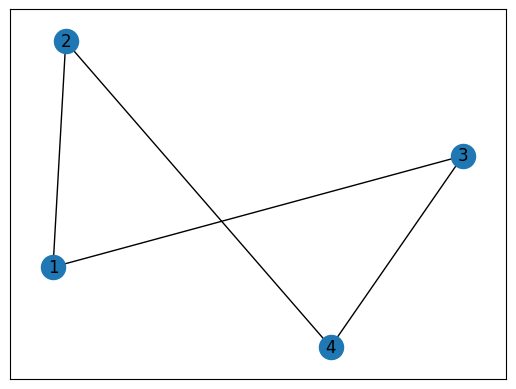

In [15]:
nx.draw_networkx(G)

### Main

In [26]:
_V, argmax = findMaxJointPayoff(f_lambda, h_lambda, K, U, x0, delta_time, m)
x = computeDynamic(f_lambda, argmax, x0, delta_time)

df = 0.1

V = computeCharacteristicFunction(h_lambda, K, x, delta_time, m, df)
printCharacteristicFunction(V, df)

Sh = computeShapleyVector(V, n)
print([round(i, 2) for i in Sh])
# print(x[0, :])

Characteristic function for discount_factor = 0.1:

V(∅) = 0
V({1}) = 6.04
V({2}) = 4.71
V({3}) = 0.0
V({4}) = 1.02
V({1, 2}) = 60.38
V({1, 3}) = 38.94
V({1, 4}) = 7.06
V({2, 3}) = 4.71
V({2, 4}) = 19.92
V({3, 4}) = 10.2
V({1, 2, 3}) = 93.28
V({1, 2, 4}) = 75.59
V({1, 3, 4}) = 49.14
V({2, 3, 4}) = 29.1
V({1, 2, 3, 4}) = 117.67
[47.3, 36.62, 21.04, 12.71]


In [67]:
df = 0.5
step_size = 10

def checkShOrder(u: np.ndarray) -> tuple[dict[int, np.ndarray], np.ndarray]:
  Sh_arr = computeShDynamicByU(f_lambda, h_lambda, K, u, x0, delta_time, m, df)
  Sh_arr_sorted = [sorted(range(1, 5), key = lambda i: Sh[i-1], reverse=True) for Sh in Sh_arr]
  ans_dict = dict()
  ans_dict[1] = Sh_arr_sorted[1]
  # print(f"1: {Sh_arr_sorted[1]}")
  for k in range(2, len(Sh_arr_sorted)):
    if Sh_arr_sorted[k] != Sh_arr_sorted[k - 1]:
      ans_dict[k] = Sh_arr_sorted[k]
      # print(f"{k}: {Sh_arr_sorted[k]}")
  # for i in range(n):
  #  plt.plot(range(len(Sh_arr)), Sh_arr[:, i], label = f"Sh_{i}")
  #  plt.legend()
  #  plt.show()
  return ans_dict, Sh_arr

While using test strategies Sh changes its order 0 times: {1: [2, 1, 4, 3]}


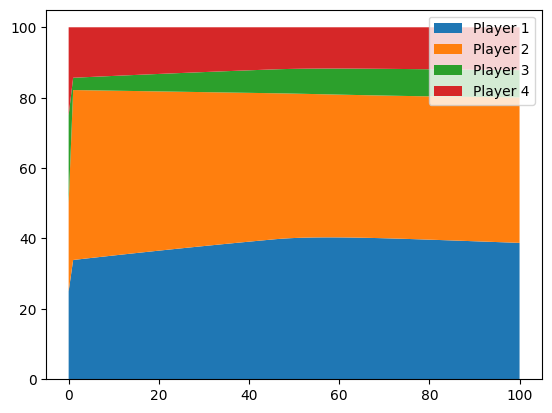

In [104]:
np.set_printoptions(suppress=True)

v, argmax = findMaxJointPayoff(f_lambda, h_lambda, K, U, x0, delta_time, m)
opt_u = argmax.reshape((n, m)) # 1 -1 1 1

test_u = opt_u.copy()
test_u[0, 46:] = -1 # from 5: to 46:

opt_changes, Sh_arr = checkShOrder(test_u)
print(f"While using test strategies Sh changes its order {len(opt_changes) - 1} times: {opt_changes}")
x = range(len(Sh_arr))
Y = np.array([(Sh/sum(Sh) * 100) if sum(Sh) > 1e-6 else np.full(len(Sh), 100/len(Sh)) for Sh in Sh_arr]).T
plt.stackplot(x, Y, baseline="zero", labels = [f"Player {i}" for i in range(1, 5)])
plt.axis('tight')
plt.legend()
plt.show()

# for k in range(m):
#   prefix = ">>>     " if k in opt_changes.keys() and k != 1 else ""
#   print(f"{k}: {prefix}{np.around(Sh_arr, 2)[k, :]}")
# test_u = np.ones((n, m))
# test_changes, Sh_arr = checkShOrder(test_u)
# print(f"While using test strategies Sh changes its order {len(test_changes) - 1} times: {test_changes}")

# test_u = np.ones((n, m))

np.set_printoptions(suppress=False)

Actual MaxJointPayoff: 117.66767381228678
First stage finished!
Second stage finished!
Third stage finished!
Total MaxJointPayoff: 117.66767381228678





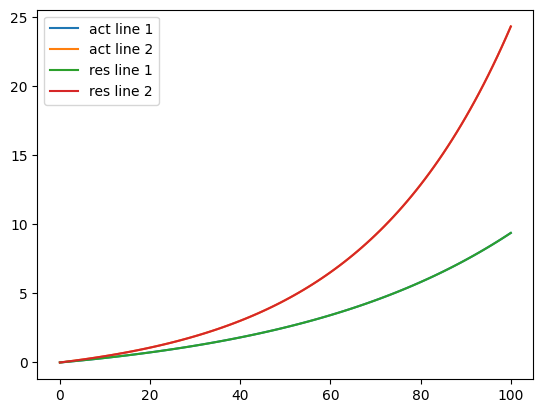

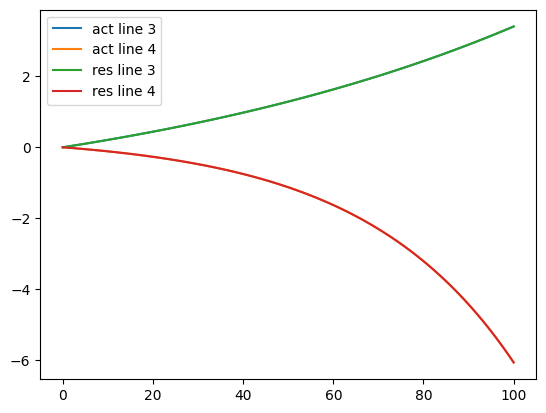

In [58]:
first_split = 1
second_split = 2
Vs = []
argmaxs = []
x_arr = []

x_0 = x0
V, argmax = findMaxJointPayoff(f_lambda, h_lambda, K, U, x_0, delta_time, m)
act_x = computeDynamic(f_lambda, argmax, x_0, delta_time)
act_argmax = argmax.reshape(n, m)
print(f"Actual MaxJointPayoff: {V}")

x_0 = x0
argmax = act_argmax[:, :first_split]
Vs += [computeJointPayoff(f_lambda, h_lambda, K, argmax, x_0, delta_time, False)]
argmaxs += [argmax]
x_arr += [computeDynamic(f_lambda, argmax, x_0, delta_time)]
print("First stage finished!")

x_0 = x_arr[0][:, -1]
V, argmax = findMaxJointPayoff(f_lambda, h_lambda, K, U, x_0, delta_time, second_split - first_split, False)
Vs += [V]
argmaxs += [argmax.reshape(n, second_split - first_split)]
x_arr += [computeDynamic(f_lambda, argmax, x_0, delta_time)[:, 1:]]
print("Second stage finished!")

x_0 = x_arr[1][:, -1]
V, argmax = findMaxJointPayoff(f_lambda, h_lambda, K, U, x_0, delta_time, m - second_split)
Vs += [V]
argmaxs += [argmax.reshape(n, m - second_split)]
x_arr += [computeDynamic(f_lambda, argmax, x_0, delta_time)[:, 1:]]
print("Third stage finished!")

res_argmax = np.concatenate(argmaxs, axis=1)
res_x = np.concatenate(x_arr, axis=1)
print(f"Total MaxJointPayoff: {sum(Vs)}")

print()

print()

# print("Argmaxes: " + str([res_argmax[:, i] for i in (0, 51)]))
# print("Actual Argmaxes: " + str([act_argmax[:, i] for i in (0, 51)]))
# bet_argmax = act_argmax.copy()
# for i in range(60, m):
#   bet_argmax[2:4, i] = -1
# print("Better Argmaxes: " + str([bet_argmax[:, i] for i in (0, 51)]))
# V = computeJointPayoff(f_lambda, h_lambda, K, bet_argmax, x0, delta_time)
# print(f"Better JointPayoff: {V}")
# bet_x = computeDynamic(f_lambda, bet_argmax, x0, delta_time)

print()

plt.plot(range(m + 1), act_x[0], label = "act line 1")
plt.plot(range(m + 1), act_x[1], label = "act line 2")
plt.plot(range(m + 1), res_x[0], label = "res line 1")
plt.plot(range(m + 1), res_x[1], label = "res line 2")
plt.legend()
plt.show()
plt.plot(range(m + 1), act_x[2], label = "act line 3")
plt.plot(range(m + 1), act_x[3], label = "act line 4")
plt.plot(range(m + 1), res_x[2], label = "res line 3")
plt.plot(range(m + 1), res_x[3], label = "res line 4")
# plt.plot(range(m + 1), bet_x[2], label = "bet line 3")
# plt.plot(range(m + 1), bet_x[3], label = "bet line 4")
plt.legend()
plt.show()

print()

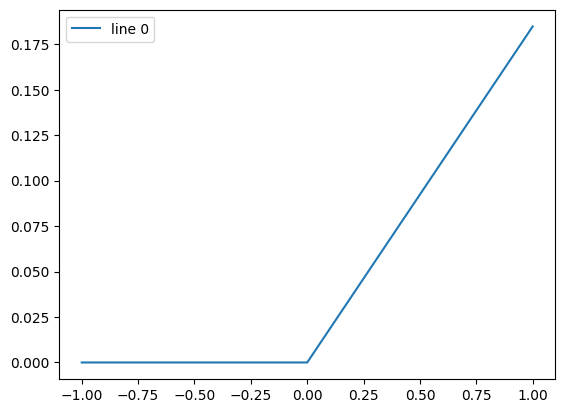

In [118]:
x_plot = np.linspace(-1, 1, 201)
y_plot = np.zeros(201)
u_others = np.linspace(0, 0, 1)
for j in range(u_others.size):
  for i in range(x_plot.size):
    u_arr = np.full((n, m + 1), u_others[j]).flatten()
    u_arr[0 * (m + 1) + 30] = x_plot[i]
    y_plot[i] = computeJointPayoff(f_lambda, h_lambda, K, u_arr, x0, delta_time, True)
  plt.plot(x_plot, y_plot, label = "line " + str(j))
plt.legend()
plt.show()

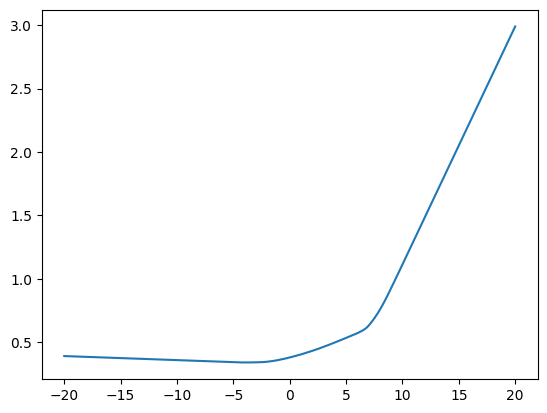

In [145]:
x_plot = np.linspace(-20, 20, 500)
y_plot = np.zeros(500)
u_arr = np.random.uniform(-1, 1, (n, m)).flatten()
for i in range(x_plot.size):
  u_arr[30] = x_plot[i]
  y_plot[i] = computeJointPayoff(f_lambda, h_lambda, K, u_arr, x0, delta_time, True)
plt.plot(x_plot, y_plot, label = "line " + str(j))

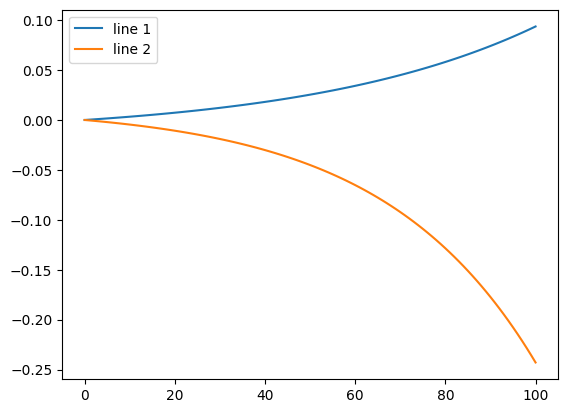

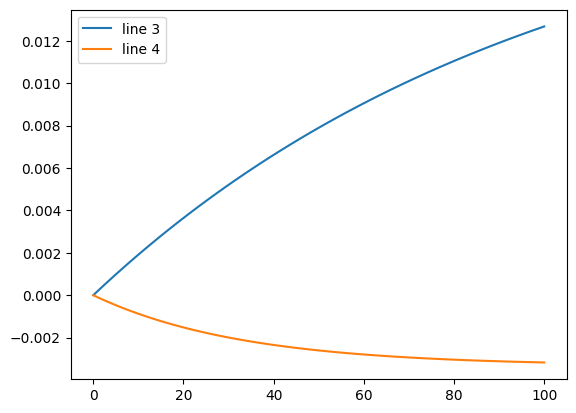

In [136]:
u_arr = np.full((n, m), 0.01)
# u_arr = np.random.uniform(0, 1, (n, m + 1)).flatten()
# print(u_arr)
# x_arr[i, j] = x_arr[i, j - 1] + delta_time * f_lambda[i](x_arr[i, j - 1], u_arr[i, j - 1])
x_arr = computeDynamic(f_lambda, u_arr, x0, delta_time)
# print("\n".join([str(i) + ": " + str(round(x_arr[0][i], 4)) for i in range(x_arr[0].size)]))
plt.plot(range(m + 1), x_arr[0], label = "line 1")
plt.plot(range(m + 1), x_arr[1], label = "line 2")
plt.legend()
plt.show()
plt.plot(range(m + 1), x_arr[2], label = "line 3")
plt.plot(range(m + 1), x_arr[3], label = "line 4")
plt.legend()
plt.show()

(4, 27)


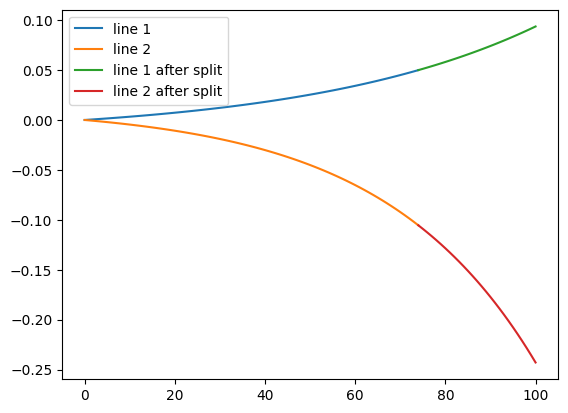

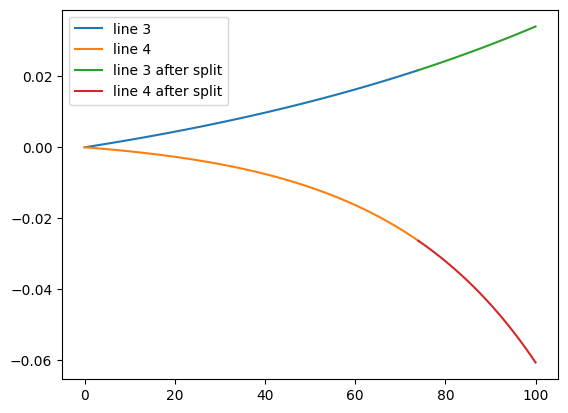

In [293]:
m_split = 75
u_arr = np.full((n, m), 0.01)
x_arr = computeDynamic(f_lambda, u_arr[:, :m_split - 1], x0, delta_time)

x_arr_1 = computeDynamic(f_lambda, u_arr[:, m_split - 1:], x_arr[:, -1], delta_time)
print(x_arr_1.shape)
# print("\n".join([str(i) + ": " + str(round(x_arr[0][i], 4)) for i in range(x_arr[0].size)]))

plt.plot(range(m_split), x_arr[0], label = "line 1")
plt.plot(range(m_split), x_arr[1], label = "line 2")
plt.plot(range(m_split - 1, m + 1), x_arr_1[0], label = "line 1 after split")
plt.plot(range(m_split - 1, m + 1), x_arr_1[1], label = "line 2 after split")
plt.legend()
plt.show()
plt.plot(range(m_split), x_arr[2], label = "line 3")
plt.plot(range(m_split), x_arr[3], label = "line 4")
plt.plot(range(m_split - 1, m + 1), x_arr_1[2], label = "line 3 after split")
plt.plot(range(m_split - 1, m + 1), x_arr_1[3], label = "line 4 after split")
plt.legend()
plt.show()

### Old cells

In [ ]:
'''def getJointPayoffAsSympyExpr():
  x_arr = []
  for i in range(n):
    x_arr.append([])
    x_arr[i].append(x[i, 0].subs(x[i, 0], x0[i]))
    for j in range(1, m + 1):
      expr = x[i, j - 1] + delta_time * f[i].subs([(a, x[i, j - 1]), (b, u[i, j - 1])])
      expr = expr.subs(x[i, j - 1], x_arr[i][j - 1])
      x_arr[i].append(expr)
  print(x_arr)
  sum = x[i, 0] - x[i, 0]
  for i in range(n):
    for j in K[i]:
      for k in range(m + 1):
        sum += h[(i, j)].subs([(a, x_arr[i][k]), (b, x_arr[j][k])])
  sum = sum * delta_time
  return sum'''

'''def computeJointPayoff_alt(u_arr: np.ndarray) -> float:
  u_arr = u_arr.reshape(n, m + 1)
  args = [(u[0, 0], u_arr[0, 0])] * (n * (m + 1))
  for i in range(n):
    for j in range(m + 1):
      args[i * (m + 1) + j] = (u[i, j], u_arr[i, j])
  return fun_expr.subs(args)

def computeJointPayoffDerivative_alt(u_arr: np.ndarray) -> list[float]:
  u_arr = u_arr.reshape(n, m + 1)
  args = [(u[0, 0], u_arr[0, 0])] * (n * (m + 1))
  for i in range(n):
    for j in range(m + 1):
      args[i * (m + 1) + j] = (u[i, j], u_arr[i, j])
  ans = np.empty((n, m + 1))
  for i in range(n):
    for j in range(m + 1):
      expr = diff_expr[i * (m + 1) + j].subs(args)
      print(expr)
      ans[i][j] = expr
  return ans.flatten()
'''

# fun_expr = getJointPayoffAsSympyExpr()

'''def getJointPayoffDerivativeAsSympyExpr():
  ans = []
  for i in range(n):
    for j in range(m + 1):
      print(j)
      derivative = sp.diff(fun_expr, u[i, j])
      ans.append(derivative)
  return ans'''

# diff_expr = getJointPayoffDerivativeAsSympyExpr()
print()

In [184]:
def Bellman(
    x: np.ndarray, # state of the system on the current iteration
    iter: int, # current iteration index
    f: list[Callable[[float, float], float]], # dynamic of the system; size must be equal to the number of players
    h: dict[tuple[int, int], Callable[[float, float], float]], # payoff of the first player for connecting with second player; must be set for all edges of the graph
    K: list[list[int]], # for each players contains list of their neighbors
    bounds: list[tuple[float, float]], # for each player contains lower and upper bounds for possible control inputs
    delta_time: float, # time between two adjust timestamps
    ) -> float:
  # print(f"New iteration! x = {x}; iter = {iter}")
  sum = 0
  for i in range(n):
    for j in K[i]:
      sum += h[(i, j)](x[i], x[j])
  sum = sum * delta_time
  if iter == 0:
    return sum
  else:
    max_v = minimize(
        lambda u: -Bellman(x + delta_time * np.array([f[i](x[i], u[i]) for i in range(len(f))]), iter - 1, f, h, K, bounds, delta_time),
        np.random.uniform(-1, 1, n),
        bounds = bounds,
        # callback = printTempResult
        )
    return -max_v.fun + sum


In [56]:
def findMaxJointPayoff_alt(
    f: list[Callable[[float, float], float]], # dynamic of the system; size must be equal to the number of players
    h: dict[tuple[int, int], Callable[[float, float], float]], # payoff of the first player for connecting with second player; must be set for all edges of the graph
    f_deriv: list[tuple[Callable[[float, float], float], Callable[[float, float], float]]], # for each player contains two partial derivatives of their state dynamic
    h_deriv: dict[tuple[int, int], tuple[Callable[[float, float], float], Callable[[float, float], float]]], # for each edge of graph contains two partial derivatives of player connections payoff function
    K: list[list[int]], # for each players contains list of their neighbors
    bounds: list[tuple[float, float]], # for each player contains lower and upper bounds for possible control inputs
    x0: np.ndarray, # initial state of the system; size must be equal to the number of players
    delta_time: float, # time between two adjust timestamps
    u0: np.ndarray, # initial control inputs array; shape must be equal to (n, m), where n is the number of players and m is the number of timestamps
    final_computation = True # if you compute JointPayoff gradually (with splits in timestamps array), this bool must be set to False for all but final step
) -> tuple[float, np.ndarray]:
  n, m = u0.shape

  # bounds must be set for all u[i, j]; not just for u[i]
  bounds_expanded = [U[0]] * m
  for i in range(1, n):
    bounds_expanded += [U[i]] * m

  res = minimize(
      lambda t: -computeJointPayoff(f, h, K, t, x0, delta_time, final_computation),
      u0.flatten(),
      bounds = bounds_expanded,
      jac = lambda t: -computeJointPayoffDerivative(f, f_deriv, h_deriv, K, t, x0, delta_time),
      # callback = printTempResult
      )
  return (-res.fun, res.x)